In [1]:
%matplotlib inline
import yfinance as yf
import talib
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from factors import factory as fty

In [329]:
symbols = sorted(['AAPL','SPG','BYND','BILI','NIO','WORK','PYPL','BABA','NFLX'])
data = yf.download(symbols,period='3y',interval='1d')

tmp = data.xs('AAPL', axis=1,level=1,drop_level=True).dropna()
tmp.columns
df = pd.DataFrame()
df['Close']=tmp['Close']
df['Volume']=tmp['Volume']
df=tmp
df = data.copy()
df.tail()


[*********************100%***********************]  9 of 9 completed


Adj Close                                                 \
                  AAPL        BABA       BILI        BYND        NFLX   
Date                                                                    
2020-11-09  116.320000  290.529999  46.040001  150.500000  470.500000   
2020-11-10  115.970001  266.540009  43.700001  125.010002  480.239990   
2020-11-11  119.489998  265.649994  44.200001  127.889999  490.760010   
2020-11-12  119.209999  264.309998  45.900002  128.899994  486.769989   
2020-11-13  119.260002  260.839996  48.900002  124.739998  482.839996   

                                                              Close  ...  \
                  NIO        PYPL        SPG       WORK        AAPL  ...   
Date                                                                 ...   
2020-11-09  44.020000  184.720001  79.099998  25.790001  116.320000  ...   
2020-11-10  41.549999  183.360001  78.839996  24.100000  115.970001  ...   
2020-11-11  43.080002  192.339996  73.410004  25.170000  119.489998  ...   
2020-11-12  48.299999  189.100006  69.139999  25.889999  119.209999  ...   
2020-11-13  44.560001  188.619995  74.699997  25.750000  119.260002  ...   

                 Open     Volume                                             \
                 WORK       AAPL      BABA       BILI        BYND      NFLX   
Date                                                                          
2020-11-09  25.600000  154515300  22559900  5775800.0  21307500.0  10419700   
2020-11-10  25.590000  138023400  61064000  8128400.0  29678100.0   8306100   
2020-11-11  24.600000  112295000  41699000  5303500.0   7151600.0   5460500   
2020-11-12  25.549999  103162300  27119100  5024900.0   6376800.0   5063700   
2020-11-13  26.280001   81581900  33942800  6010400.0   5332200.0   3002700   

                                                         
                    NIO      PYPL       SPG        WORK  
Date                                                     
2020-11-09  218733300.0  18986400  24996200  12447000.0  
2020-11-10  237403600.0  13144300  14440400  20180000.0  
2020-11-11  179581200.0   9151700   6844600  13145300.0  
2020-11-12  345932900.0   7096100   8143000   8471400.0  
2020-11-13  577185100.0   6017200   7732900   6918100.0  

[5 rows x 54 columns]

In [345]:
high_name = 'High'
low_name='Low'
open_name = 'Open'
close_name = 'Close'
vol_name = 'Volume'
st_buy_sig,st_sell_sig,super_trend_line, df = fty.super_trend_vpt(df,'Close')

#super trend upper|lower level
high_low = (df[high_name] - df[low_name]) * 100
open_close = (df[close_name] - df[open_name]) * 100
spread_vol = open_close * df[vol_name] / high_low
vpt = spread_vol + spread_vol.cumsum()

price_spread = (df[high_name] - df[low_name]).rolling(28).std()
avg_vpt = vpt.rolling(14).mean()
shadow = price_spread * (vpt - avg_vpt) / (vpt - avg_vpt).rolling(28).std()

tmp_high = df[high_name][shadow > 0] + shadow[shadow > 0]

tmp_low = df[low_name][shadow < 0] + shadow[shadow < 0]
tmp = tmp_high.combine_first(tmp_low)

vpt = tmp.ewm(alpha=2 / (10 + 1), adjust=False).mean()

atr = fty.get_atr(df)
up_lev = vpt - 1 * atr
dn_lev = vpt + 1 * atr

df=fty.append_macd_cols(df,'Close')
df=fty.append_rsi_cols(df,'Close')

df=fty.append_bollinger_band_cols(df,'Close')
df=fty.append_bollinger_band_cols(df,'Close',timeperiod=60)


In [353]:
#first level col names
df.columns.levels[0]

Index(['Adj Close', 'BB_DIFF_120', 'BB_DIFF_60', 'BB_LOW_120', 'BB_LOW_60',
       'BB_MID_120', 'BB_MID_60', 'BB_UP_120', 'BB_UP_60', 'Close', 'High',
       'Low', 'MACD_12_26_9', 'MACD_SIG_12_26_9', 'Open', 'RSI_14', 'VPT',
       'Volume'],
      dtype='object')

# plot stock price 

In [365]:
symbol = 'BYND'
price_df = pd.DataFrame()
price_df['price']= (df['Close']+df['Open'] )[symbol]/2

'''
fig2 = go.Figure(data=go.Ohlc(x = df.index, 
                             open = df['Open',symbol],
                             high = df['High',symbol],
                            low = df['Low',symbol],
                            close = df['Close',symbol]))
fig2.show()
'''



for i in [5,10,14, 21,30,60,120,250]:
    price_df['ema_%s'%i]=talib.EMA(df['Close',symbol], timeperiod=i)


price_df['st_line']=super_trend_line[symbol][super_trend_line[symbol]!=0]
low_band = price_df['st_line'][price_df['price']> price_df['st_line']]
up_band = price_df['st_line'][price_df['price']< price_df['st_line']]

#macd
price_df['macd'] = df['MACD_12_26_9'][symbol]
price_df['macd_sig'] = df['MACD_SIG_12_26_9'][symbol]

#rsi 
price_df['rsi'] = df['RSI_14'][symbol]

#bb_band
price_df['bbu_slw'] = df['BB_UP_120'][symbol]
price_df['bbm_slw'] = df['BB_MID_120'][symbol]
price_df['bbl_slw'] = df['BB_LOW_120'][symbol]

price_df['bbu_fst'] = df['BB_UP_60'][symbol]
price_df['bbm_fst'] = df['BB_MID_60'][symbol]
price_df['bbl_fst'] = df['BB_LOW_60'][symbol]


price_df['position']=0
price_df['side']=0
price_df = price_df.dropna()

tmp = price_df[['ema_5','ema_10','ema_14','ema_21','ema_30','ema_60','ema_120','ema_250']]
#fig = make_subplots(specs=[[{"secondary_y": True}]])
fig = make_subplots( specs=[[{"secondary_y": True}],[{"secondary_y": True}],[{"secondary_y": True}]],
                    rows=3, cols=1,row_heights=[1.6, 0.5,0.5])
fig.update_layout(title=symbol,autosize=False,width=1000,height=1000,
                  xaxis_rangeslider_visible=False)

fig.add_trace(go.Candlestick(x = df.index, 
                             open = df['Open',symbol],
                             high = df['High',symbol],
                            low = df['Low',symbol],
                            close = df['Close',symbol]))

fig.add_trace(go.Bar(x=df.index, y=df['Volume',symbol], name='volume', opacity=0.3,marker=dict(color="#396afa"))
                 , secondary_y=True)

# Add ema trace
for col in tmp.columns:
    color = '#ffbaba'
    fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=tmp[col], name=col, opacity=opacity,
                             line=dict(color=color)))

#low/up band stline

fig.add_trace(go.Scatter(mode='markers',x=low_band.index, y=low_band, name='low_line', opacity=0.8,
                             marker=dict(color="#36ff00", symbol="triangle-up", size=8)))
fig.add_trace(go.Scatter(mode='markers',x=up_band.index, y=up_band, name='up_line', opacity=0.8,
                             marker=dict(color="#001aff", symbol="triangle-down", size=8)))


fig.add_trace(go.Scatter(mode='markers',x=up_lev.index, y=up_lev[symbol], name='up_lev', opacity=0.5,
                             marker=dict(color="#36ff00",symbol='cross')))

fig.add_trace(go.Scatter(mode='markers',x=dn_lev.index, y=dn_lev[symbol], name='dn_lev', opacity=0.5,
                             marker=dict(color="#001aff",symbol='cross')))




#macd
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=price_df['macd'], name='macd', opacity=1,
                             line=dict(color="#ff2600")), row=2,col=1)
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=price_df['macd_sig'], name='macd_sig', opacity=1,
                             line=dict(color="#ffc800")), row=2,col=1)

#rsi 
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=[75]*len(price_df.index), opacity=1,showlegend=False,
                             line=dict(color="#9e9e9e",dash = 'dash')), row=3,col=1)
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=[25]*len(price_df.index), opacity=1,showlegend=False,
                             line=dict(color="#9e9e9e",dash = 'dash')), row=3,col=1)
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=price_df['rsi'], name='rsi', opacity=1,
                             line=dict(color="#ff2600")), row=3,col=1)


#bb_band
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=price_df['bbu_slw'], name='bbu_slw', opacity=1,
                             line=dict(color="#64b0a5")), )
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=price_df['bbm_slw'], name='bbm_slw', opacity=1,
                             line=dict(color="#64b0a5",dash = 'dash')), )
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=price_df['bbl_slw'], name='bbl_slw', opacity=1,
                             line=dict(color="#64b0a5")), )


fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=price_df['bbu_fst'], name='bbu_fst', opacity=1,
                             line=dict(color="#cf9667")), )
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=price_df['bbm_fst'], name='bbm_fst', opacity=1,
                             line=dict(color="#cf9667",dash = 'dash')), )
fig.add_trace(go.Scatter(mode='lines',x=price_df.index, y=price_df['bbl_fst'], name='bbl_fst', opacity=1,
                             line=dict(color="#cf9667")), )


fig.show()


In [314]:


fig = make_subplots( vertical_spacing = 0, rows=2, cols=1)

fig.add_trace(go.Ohlc(x = df.index, 
                             open = df['Open',symbol],
                             high = df['High',symbol],
                            low = df['Low',symbol],
                            close = df['Close',symbol]))

fig.add_trace(go.Scatter(mode='lines+markers',x=df.index, y=df['Open',symbol], name='open', opacity=0.8,
                             line=dict(color="#9eb6ff"))
                  
                 )

fig.add_trace(go.Scatter(mode='lines+markers',x=df.index, y=df['Close',symbol], name='close', opacity=0.8,
                             line=dict(color="#396afa"))
                  
                 )

fig.add_trace(go.Bar(x=df.index, y=df['Volume',symbol], name='volume', opacity=1,marker=dict(color="#396afa"))
                 , row=2,col=1)

fig.update_layout(xaxis_rangeslider_visible=False,
                  xaxis=dict(zerolinecolor='red', showticklabels=False),
                  xaxis2=dict(showticklabels=True))

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=False)

fig.show()

# signal's future return 

In [232]:
price= price_df['price']
price_buy = price[st_buy_sig[symbol]==True]
price_sell = price[st_sell_sig[symbol]==True]
 
days = [5, 10, 14, 21, 60 , 120]
plot_data=[]
colors = ["#ff0000", "#ffaa00", "#f2ff00", "#48ff00","#0022ff", "#d900ff"]
#return after x days
for i in range(len(days)) :
    day = days[i]
    color = colors[i]
    return_buy=price.shift(-day)/price -1 
    return_buy=return_buy[st_buy_sig[symbol]==True]
    plot_data.append(go.Scatter(mode='lines+markers',x=return_buy.index, y=return_buy, 
                                name='buy_%s'%day, opacity=1,
                             line=dict(color=color)))
    return_sell=((price.shift(-day)/price -1)*-1)[st_sell_sig[symbol]==True]
    plot_data.append(go.Scatter(mode='lines+markers',x=return_sell.index, y=return_sell, 
                                name='sell_%s'%day, opacity=0.5,
                             line=dict(color=color, dash = 'dash')))
    
    print(pd.concat([return_buy, return_sell]).dropna().describe())
    
fig = go.Figure(data=plot_data)
fig.show()



count    177.000000
mean       0.001399
std        0.009070
min       -0.059308
25%       -0.001383
50%        0.000793
75%        0.003233
max        0.050387
Name: price, dtype: float64
count    177.000000
mean       0.001027
std        0.019882
min       -0.199245
25%       -0.002556
50%        0.000737
75%        0.005205
max        0.088810
Name: price, dtype: float64
count    176.000000
mean       0.001350
std        0.030770
min       -0.282109
25%       -0.002808
50%        0.000791
75%        0.007050
max        0.207558
Name: price, dtype: float64
count    175.000000
mean       0.001754
std        0.042070
min       -0.298947
25%       -0.004813
50%        0.001242
75%        0.007115
max        0.292563
Name: price, dtype: float64
count    170.000000
mean       0.001900
std        0.053752
min       -0.261420
25%       -0.011282
50%        0.001698
75%        0.012957
max        0.290824
Name: price, dtype: float64
count    167.000000
mean       0.000141
std        0.064606


In [237]:
up_lev

,AAPL,SPG
Datetime,,
2020-11-05 09:30:00-05:00,NaN,NaN
2020-11-05 09:31:00-05:00,NaN,NaN
2020-11-05 09:32:00-05:00,NaN,NaN
2020-11-05 09:33:00-05:00,NaN,NaN
2020-11-05 09:34:00-05:00,NaN,NaN
2020-11-05 09:35:00-05:00,NaN,NaN
2020-11-05 09:36:00-05:00,NaN,NaN
2020-11-05 09:37:00-05:00,NaN,NaN
2020-11-05 09:38:00-05:00,NaN,NaN


/Users/ZhenxinLei/riverrocktech/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



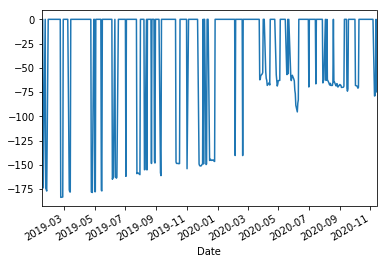

In [59]:
#stline> price
#price_df['side'][price_df['st_line']/price_df['price']-1>0.05]=1
price_df['side'][(price_df['st_line']/price_df['price']-1<0.02) & (price_df['st_line']>price_df['price'])]=-1

#stline< price 
price_df['side'][price_df['st_line']/price_df['price']-1<-0.05]=-1
#price_df['side'][(price_df['st_line']/price_df['price']-1>-0.02) & (price_df['st_line']<price_df['price'])]=1


(price_df['side']*price_df['price']).plot()